<a href="https://colab.research.google.com/github/as791/Cat-vs-Dog/blob/master/Dog_vs_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/dogs-vs-cats')

Mounted at /content/drive


In [2]:
os.listdir()

['sampleSubmission.csv',
 'train',
 'test1',
 'X_train.npy',
 'Y_train.npy',
 'nn12.h5',
 'nn21.h5',
 'nn22.h5',
 'X_test.npy',
 'Y_pre.csv',
 'nn11.h5']

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

**Creating Data to Process**

In [0]:
mapping_label = {0:'cat',1:'dog'}

In [0]:
def img_label(img):
    word_label=img.split('.')[0]
    if word_label=='cat':
        return 0
    elif word_label=='dog':
        return 1

In [0]:
def create_train_data(path):
    X,Y=[],[]
    my_dir = os.listdir(path)
    for img in tqdm(my_dir):
        label=img_label(img)
        img_data = cv2.imread(path +'/'+img)
        interpolate = cv2.INTER_AREA
        if(img_data.shape[0]<80 or img_data.shape[1]<80):
            interpolate = cv2.INTER_LINEAR
        img_data = cv2.resize(img_data, (80, 80),interpolation=interpolate)
        X.append(img_data)
        Y.append(label)
    return X,Y

In [0]:
X_train,Y_train=create_train_data('./train')

  1%|▏         | 350/25000 [01:50<2:11:19,  3.13it/s]

In [0]:
X_train  = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [0]:
np.save('X_train.npy',X_train)
np.save('Y_train.npy',Y_train)

In [0]:
def create_test_data(path):
    X=[]
    my_dir = sorted(list(map(lambda x:int(x[:-4]),os.listdir(path))))
    for img in tqdm(my_dir):
        img_data = cv2.imread(path +'/'+ str(img) + '.jpg')
        interpolate = cv2.INTER_AREA
        if(img_data.shape[0]<80 or img_data.shape[1]<80):
            interpolate = cv2.INTER_LINEAR
        img_data = cv2.resize(img_data, (80, 80),interpolation=interpolate)
        X.append(img_data)
    return X

In [0]:
X_test = create_test_data('./test1')

100%|██████████| 12500/12500 [01:03<00:00, 195.47it/s]


In [0]:
X_test = np.asarray(X_test)

In [0]:
X_test.shape

(12500, 80, 80, 3)

**Loading Data and Preprocessing it and dividing it in test, train, validation set**

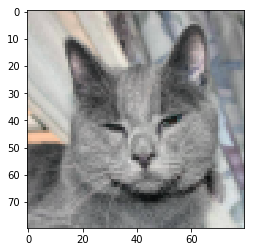

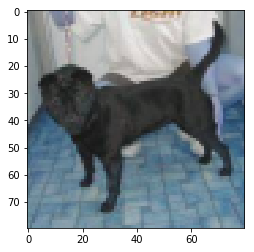

In [0]:
plt.imshow(X_train[100])
plt.show()
plt.imshow(X_test[150])
plt.show()

In [0]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train)

Using TensorFlow backend.


In [0]:
X_train.shape,Y_train.shape

((25000, 80, 80, 3), (25000, 2))

In [0]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',[0,1],np.argmax(Y_train,axis=1))
print(weights)

[1. 1.]


In [0]:
from keras.utils import normalize
X_train = normalize(X_train,axis=1)
X_test = normalize(X_test,axis=1)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train,Y_train = shuffle(X_train,Y_train,random_state = 2)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.2,random_state = 2)

In [0]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((20000, 80, 80, 3), (20000, 2), (5000, 80, 80, 3), (5000, 2))

**Proposed Models and training data on it**

In [0]:
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, regularizers, BatchNormalization, Input
import keras.optimizers as optimizers
import keras.callbacks as callbacks
from sklearn import metrics

In [0]:
input_= Input((80,80,3))
conv1  = Conv2D(64,3,padding='same',activation='relu')(input_)
pool1 = MaxPooling2D()(conv1)
norm1 = BatchNormalization()(pool1)
conv2  = Conv2D(64,3,padding='same',activation='relu')(norm1)
pool2 = MaxPooling2D()(conv2)
norm2 = BatchNormalization()(pool2)
conv3  = Conv2D(128,3,padding='same',activation='relu')(norm2)
pool3 = MaxPooling2D()(conv3)
norm3 = BatchNormalization()(pool3)
conv4  = Conv2D(256,3,padding='same',activation='relu')(norm3)
conv5  = Conv2D(256,3,padding='same',activation='relu')(conv4)
pool6 = MaxPooling2D()(conv5)
flat7 = Flatten()(pool6)
drop8 = Dropout(0.05)(flat7)
dense9 = Dense(128,activation='relu')(drop8)
dense10 = Dense(64,activation='relu')(dense9)
dense11 = Dense(2,activation='sigmoid')(dense10)

model = Model(inputs=input_,outputs=dense11)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
sgd = optimizers.SGD(lr = 0.001 ,momentum = 0.9, nesterov = False)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [0]:
history = model.fit(X_train,Y_train,epochs=25,batch_size=250,validation_data=(X_val,Y_val),callbacks=[lr_reduce])

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 13s 647us/step - loss: 0.6145 - acc: 0.6643 - val_loss: 0.6237 - val_acc: 0.6121
Epoch 2/25
20000/20000 [==============================] - 9s 456us/step - loss: 0.4568 - acc: 0.7829 - val_loss: 0.5467 - val_acc: 0.7389
Epoch 3/25
20000/20000 [==============================] - 9s 454us/step - loss: 0.3666 - acc: 0.8332 - val_loss: 0.6727 - val_acc: 0.7112
Epoch 4/25
20000/20000 [==============================] - 9s 455us/step - loss: 0.2977 - acc: 0.8711 - val_loss: 0.4354 - val_acc: 0.7980
Epoch 5/25
20000/20000 [==============================] - 9s 454us/step - loss: 0.2432 - acc: 0.8976 - val_loss: 0.3071 - val_acc: 0.8672
Epoch 6/25
20000/20000 [==============================] - 9s 457us/step - loss: 0.1894 - acc: 0.9225 - val_loss: 0.3091 - val_acc: 0.8715
Epoch 7/25
20000/20000 [==============================] - 9s 455us/step - 

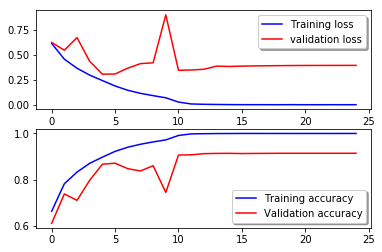

In [0]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
pred = model.predict(X_val)
Y_pred = np.argmax(pred,axis=1)
print(metrics.accuracy_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.f1_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.confusion_matrix(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.log_loss(np.argmax(Y_val,axis=1),Y_pred))

0.9138
0.9150404100137985
[[2248  228]
 [ 203 2321]]
2.9772789868841185


In [0]:
pre = model.predict(X_test)   
Y_pre = np.argmax(pre,axis=1) 

dog [3.543496e-05 9.999331e-01] 0


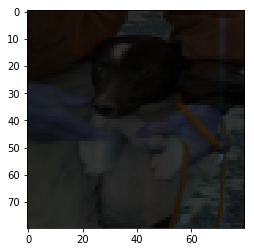

dog [0. 1.] 1


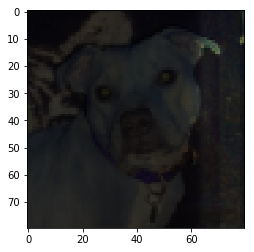

dog [0. 1.] 2


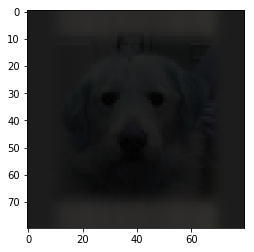

dog [2.682209e-07 9.999997e-01] 3


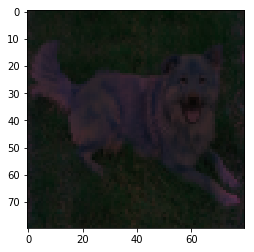

cat [0.9963623  0.00349361] 4


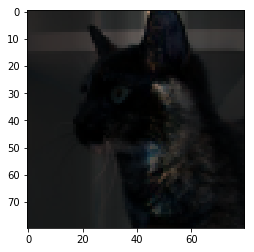

cat [9.9999690e-01 2.0861626e-06] 5


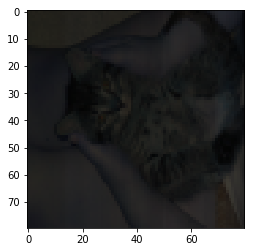

cat [1. 0.] 6


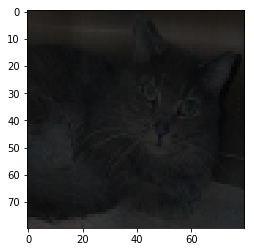

cat [0.9896203  0.01017079] 7


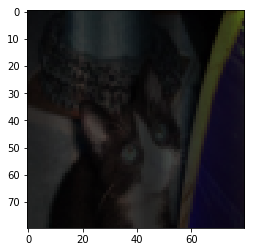

cat [9.9999988e-01 5.9604645e-08] 8


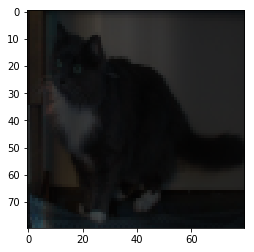

cat [9.9998677e-01 8.0168247e-06] 9


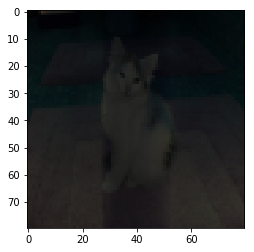

cat [9.9999964e-01 1.4901161e-07] 10


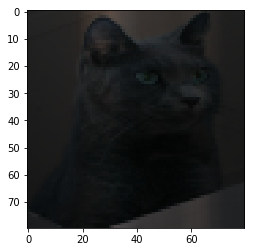

dog [5.364418e-07 9.999994e-01] 11


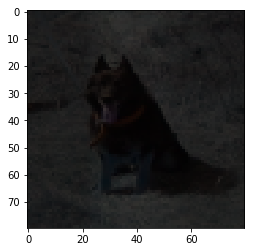

cat [9.9999964e-01 2.9802322e-07] 12


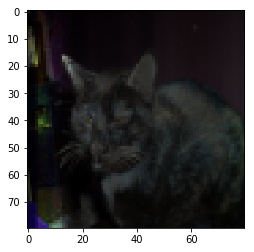

cat [9.9999464e-01 5.3048134e-06] 13


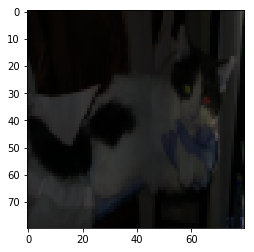

cat [9.999991e-01 8.344650e-07] 14


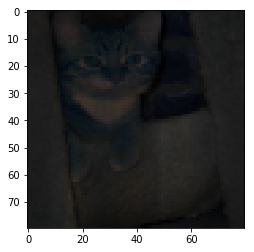

cat [9.9999988e-01 1.4901161e-07] 15


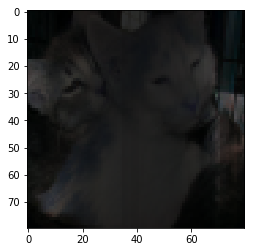

dog [0.00182486 0.99769413] 16


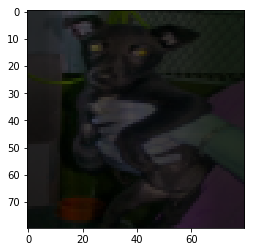

dog [3.1888485e-06 9.9999446e-01] 17


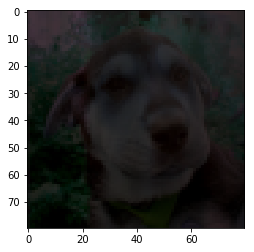

cat [9.9999285e-01 3.3080578e-06] 18


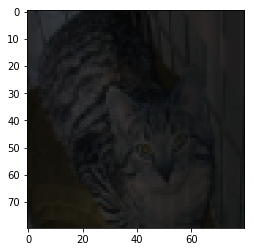

cat [0.9866029  0.01535615] 19


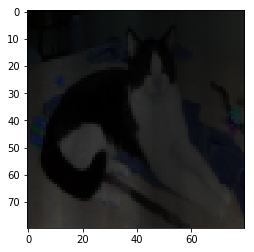

dog [0. 1.] 20


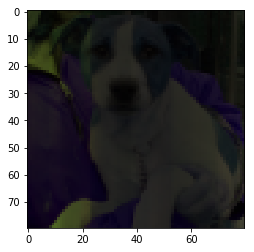

cat [1.0000000e+00 5.9604645e-08] 21


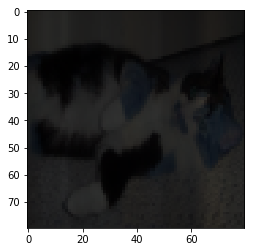

dog [1.3977289e-05 9.9997985e-01] 22


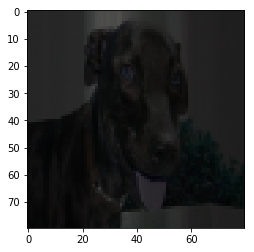

dog [9.2387199e-07 9.9999905e-01] 23


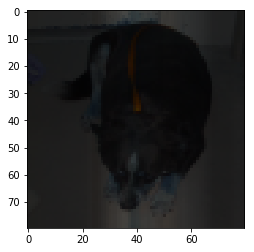

dog [0.60045385 0.6005077 ] 24


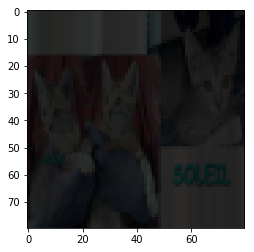

dog [0.00443643 0.9938675 ] 25


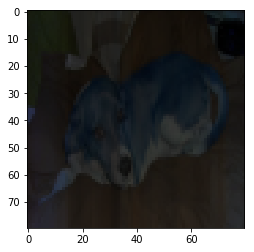

dog [1.4901161e-07 9.9999976e-01] 26


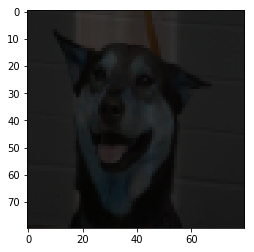

cat [1. 0.] 27


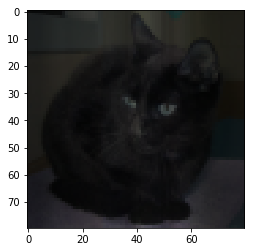

dog [2.592206e-04 9.996678e-01] 28


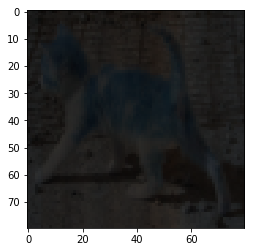

dog [1.4901161e-07 1.0000000e+00] 29


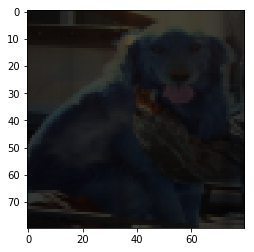

dog [2.3841858e-07 9.9999964e-01] 30


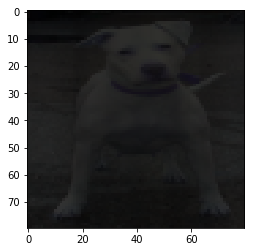

cat [9.999018e-01 9.235740e-05] 31


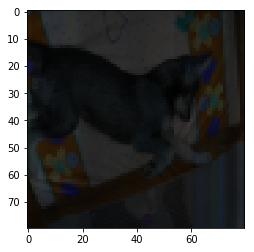

dog [5.0991774e-05 9.9992228e-01] 32


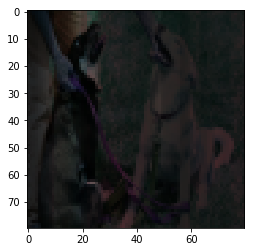

cat [9.9999595e-01 4.6193600e-06] 33


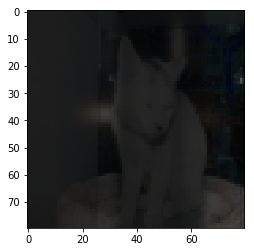

cat [1. 0.] 34


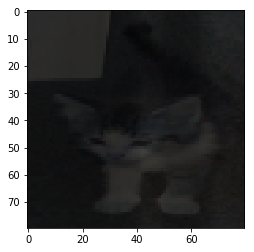

cat [9.9999952e-01 3.5762787e-07] 35


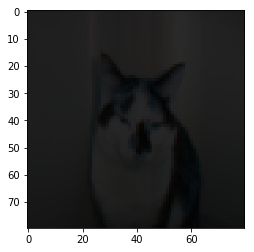

cat [1. 0.] 36


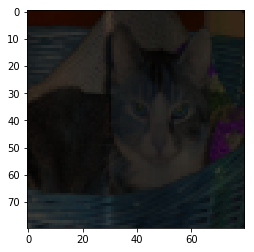

cat [1. 0.] 37


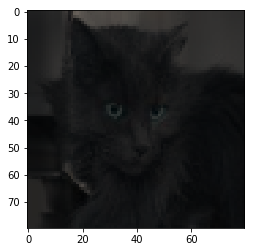

dog [5.8192015e-04 9.9937606e-01] 38


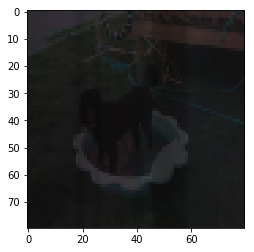

cat [9.999985e-01 1.937151e-06] 39


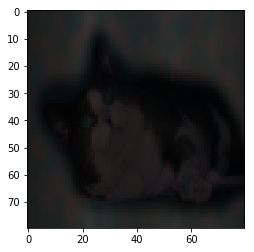

dog [1.5467405e-05 9.9997556e-01] 40


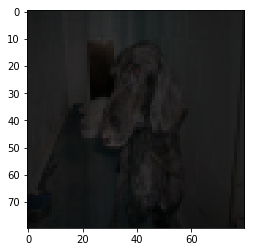

dog [0. 1.] 41


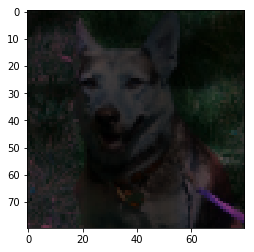

dog [0. 1.] 42


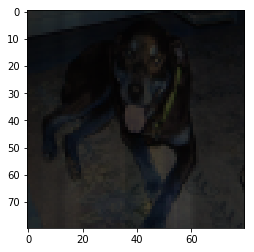

dog [0.15959042 0.8591    ] 43


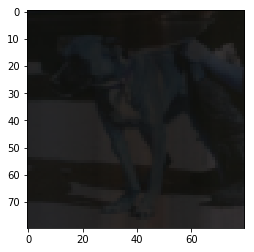

cat [1.0000000e+00 5.9604645e-08] 44


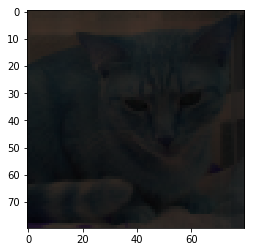

dog [3.874302e-07 9.999989e-01] 45


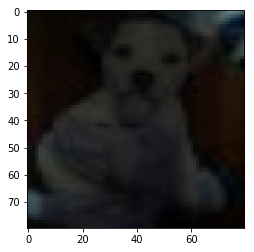

cat [1. 0.] 46


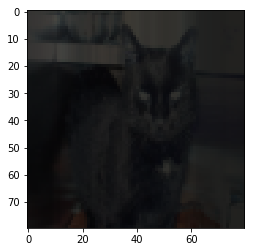

dog [2.3543835e-06 9.9999642e-01] 47


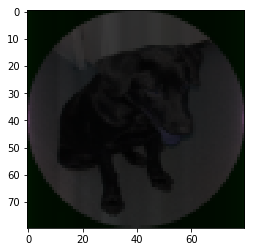

dog [8.9406967e-08 9.9999994e-01] 48


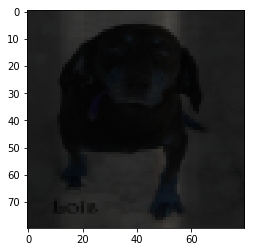

cat [9.9994147e-01 6.0647726e-05] 49


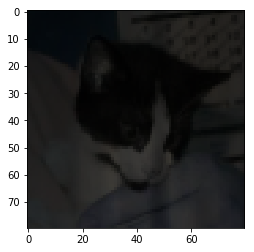

cat [9.9999988e-01 5.9604645e-08] 50


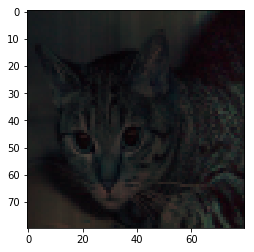

cat [9.9999905e-01 7.4505806e-07] 51


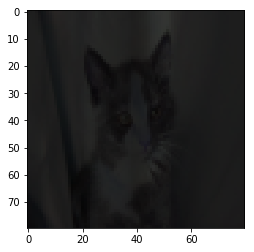

cat [0.9904747  0.01196402] 52


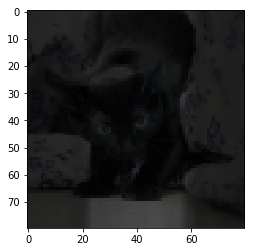

cat [9.9998713e-01 1.6659498e-05] 53


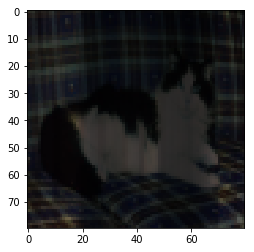

cat [0.99499905 0.006084  ] 54


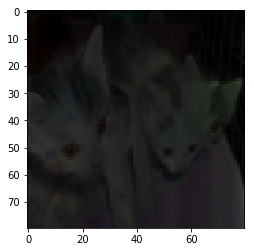

In [0]:
for i in range(55):
    plt.imshow(X_test[i])
    print(mapping_label[Y_pre[i]],pre[i],i)
    plt.show()